In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F

Učitati skup podataka $cifar10$ i za obučavanje koristiti prvih $10000$ slika iz skupa za obučavanje, a za testiranje koristiti prvih $1000$ slika iz skupa za testiranje.

In [2]:
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.utils.data as ud

indices1 = torch.arange(10000)
indices2 = torch.arange(1000)
train_dataset = ud.Subset(train_dataset, indices1)
test_dataset = ud.Subset(test_dataset, indices2)

In [4]:
len(train_dataset), len(test_dataset)

(10000, 1000)

Napraviti konvolutivnu neuronsku mrežu sa sledećom arhitekturom:
- Konvolutivni sloj sa $32$ filtera veličine $3 \times 3$ i ReLu aktivacionom funkcijom
- Konvolutivni sloj sa $32$ filtera veličine $3 \times 3$ i ReLu aktivacionom funkcijom
- Agregacioni sloj sa veličinom prozora $2 \times 2$
- Konvolutivni sloj sa $64$ filtera veličine $3 \times 3$ i ReLu aktivacionom funkcijom
- Konvolutivni sloj sa $64$ filtera veličine $3 \times 3$ i ReLu aktivacionom funkcijom
- Agregacioni sloj sa veličinom prozora $2 \times 2$
- Sloj za ravnanje (Flatten)
- Potpuno povezani sloj sa $64$ neurona i ReLu aktivacionom funkcijom
- Potpuno povezani sloj sa brojem neurona jednakim broju klasa i softmax aktivacionom funkcijom

In [5]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.flatten = nn.Flatten(start_dim=1)
        self.linear1 = nn.Linear(1600, 64)
        self.linear2 = nn.Linear(64, 10)
        # self.softmax = nn.Softmax()

    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = F.softmax(self.linear2(x))
        return x

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        loss = loss_fn(preds, y)

        # backpropagation - racunanje gradijenta
        loss.backward()
        # x_new = x - lr * grad
        optimizer.step()
        # necemo da sabiramo sve gradijente
        optimizer.zero_grad()

def test_loop(dataloader, model, loss_fn, device):
    model.eval() # ne evaluira model, samo stavlja model u eval rezim - dropout i batchnorm nisu aktivni
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            if len(outputs.shape) == 1: # accuracy - dve klase
                preds = outputs > 0 # (izlazi > 0 -> klasa 1, izlazi <= 0 -> klasa 0)
                num_same += sum(preds == y).item()
            else: # accuracy - vise klasa
                _, indices = torch.max(outputs, 1) # maks po dimenziji 1 jer je outputs.shape = (batch_size, num_classes)
                num_same += sum(indices == y).item()
        return total_loss / len(dataloader.dataset), num_same / len(dataloader.dataset)

Obučiti model - postaviti veličinu paketa (batch size) na $64$, broj epoha na $10$.

Iskoristiti $20\%$ trening podataka za validaciju.

In [8]:
model = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

model(train_dataset[0][0].reshape(1,3,32,32))

train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

epochs = 10
history = []
for epoch in range(epochs):
    train_loop(train_loader, model, loss_fn, optimizer, device)
    history.append(test_loop(test_loader, model, loss_fn, device))

C:\Users\veljk\AppData\Local\Temp\ipykernel_36492\1119638820.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear2(x))


In [9]:
n = len(history)
loss = [0 for i in range(n)]
accuracy = [0 for i in range(n)]
for i in range(n):
    loss[i], accuracy[i] = history[i]

Nacrtati grafik promene funkcije greške kroz epohe na skupu za obučavanje i za validaciju.

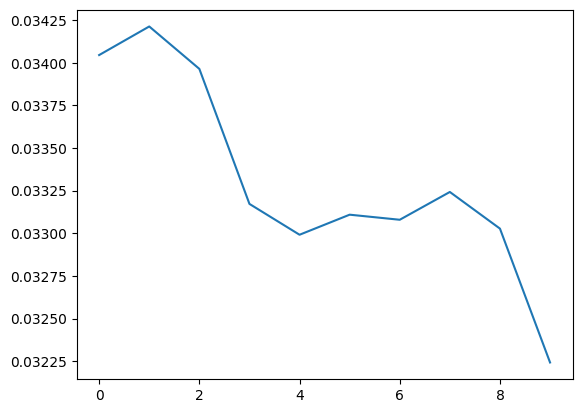

In [10]:
plt.plot(range(10), loss[:], '-')

Nacrtati grafik promene tačnosti kroz epohe na skupu za obučavanje i za validaciju.

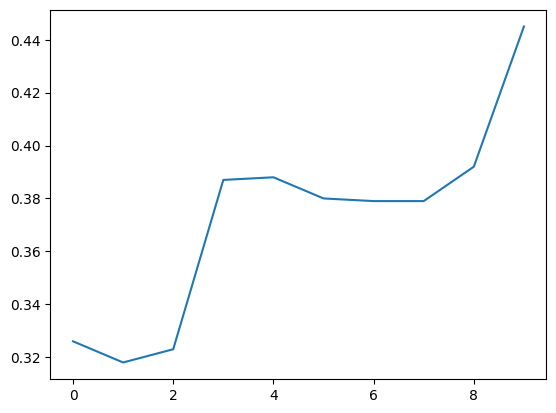

In [11]:
plt.plot(range(10), accuracy[:], '-')

Napraviti novi model koji ima istu arhitekturu kao prethodni, ali dodatno koristi regularizaciju izostavljanjem - ima $Dropout$ sloj sa faktorom $0.2$ posle svakog agregacionog sloja i između dva potpuno povezana sloja.

In [12]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.flatten = nn.Flatten(start_dim=1)
        self.linear1 = nn.Linear(1600,64)
        self.linear2 = nn.Linear(64, 10)
        # self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.softmax(self.linear2(x))
        return x


Obučiti novi model sa istim parametrima kao kod starog modela.

In [13]:
model = Net2()

model(train_dataset[0][0].reshape(1,3,32,32))

train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

epochs = 10
history = []
for epoch in range(epochs):
    train_loop(train_loader, model, loss_fn, optimizer, device)
    history.append(test_loop(test_loader, model, loss_fn, device))

C:\Users\veljk\AppData\Local\Temp\ipykernel_36492\3896964724.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear2(x))


In [14]:
n = len(history)
loss = [0 for i in range(n)]
accuracy = [0 for i in range(n)]
for i in range(n):
    loss[i], accuracy[i] = history[i]

Nacrtati oba grafika i za novi model.

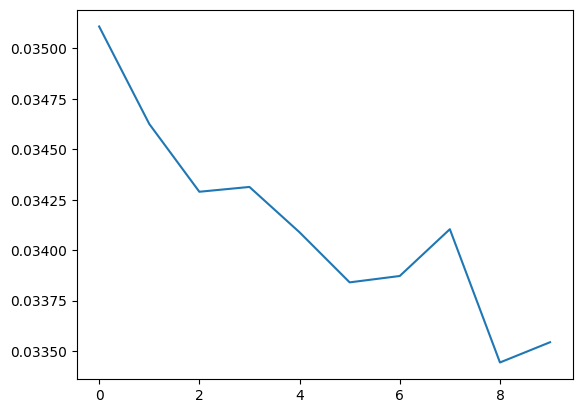

In [15]:
plt.plot(range(10), loss[:], '-')

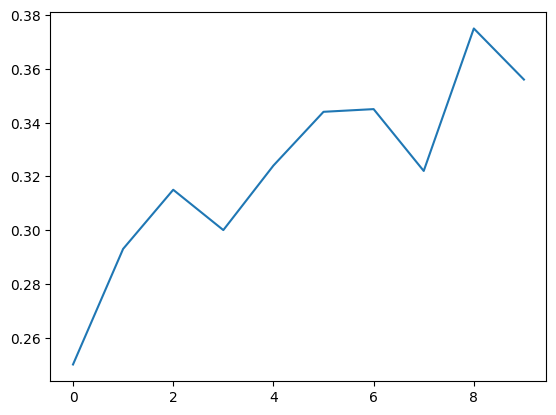

In [16]:
plt.plot(range(10), accuracy[:], '-')

Da li poređenjem ova dva grafika sa prethodna dva možete da zaključite koji model se bolje ponaša i zašto?

-
prvi je bolji, nema dovoljno podataka da bi dropout bio efikasan